In [1]:
#!/usr/bin/env python
#
#  Author: Andreas Brotzer (2024)
# -------------------------------------------------------------------------

In [2]:
import os
import yaml
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

from obspy import UTCDateTime
from pandas import read_csv, date_range, DataFrame


In [3]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/ontap-ffb-bay200/'
    lamont_path = '/home/andbro/lamont/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/import/ontap-ffb-bay200/'
    lamont_path = '/lamont/'
elif os.uname().nodename in ['lin-ffb-01', 'ambrym', 'hochfelln']:
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/import/ontap-ffb-bay200/'
    lamont_path = '/lamont/'

## Configurations

In [4]:
config = {}

config['sta'] = "VROMY"

config['tbeg'] = "2024-03-01"
config['tend'] = "2024-09-20"

config['project'] = "rolode3" # rolode | rolode3

config['fmin'], config['fmax'] = 1/11, 7.0

config['path_to_conf'] = data_path+"VelocityChanges/data/VROMY/sds/"

config['path'] = data_path+f"VelocityChanges/data/VROMY/{config['project']}/"

config['path_to_figs'] = data_path+"VelocityChanges/figures/"

# config['name'] = f"{config['project']}_{str(UTCDateTime(config['tbeg']).date).replace('-','')}"

config['col_names'] = ["frequency", "mean", "std", "mode", "median"]

config['dates'] = date_range(config['tbeg'], config['tend'])
config['dates'] = [str(_d)[:10].replace('-', '') for _d in config['dates']]

cmap = mpl.colormaps['viridis']
colors = cmap(np.linspace(0, 1, len(config['dates'])))
config['date_colors'] = {_d:_c for _d, _c in zip(config['dates'], colors)}


### Load Data

In [5]:
def __load_dispersion(mode="Love"):

    from pandas import DataFrame, concat, read_csv

    # df = DataFrame()
    data = {}

    dates = date_range(config['tbeg'], config['tend'])

    no_file = 0

    for _n, _date in enumerate(dates):

        _date_str = str(_date)[:10].replace('-','')

        filename = f"{config['project']}_{_date_str}_{mode}/"

        if os.path.isdir(config['path']+filename):
            try:
                df0 = read_csv(config['path']+f"{filename}"+"results.csv",
                               delimiter=",", header=0, names=config['col_names']
                              )
                data[_date_str] = df0
            except Exception as e:
                print(e)
        else:
            # print(f"-> no file for {filename}")
            no_file += 1

    print(f"-> no file for {no_file} dates")

    return data

In [6]:
data_love = __load_dispersion("Love")

-> no file for 156 dates


In [7]:
data_rayl = __load_dispersion("Rayleigh2")

-> no file for 156 dates


## Plotting

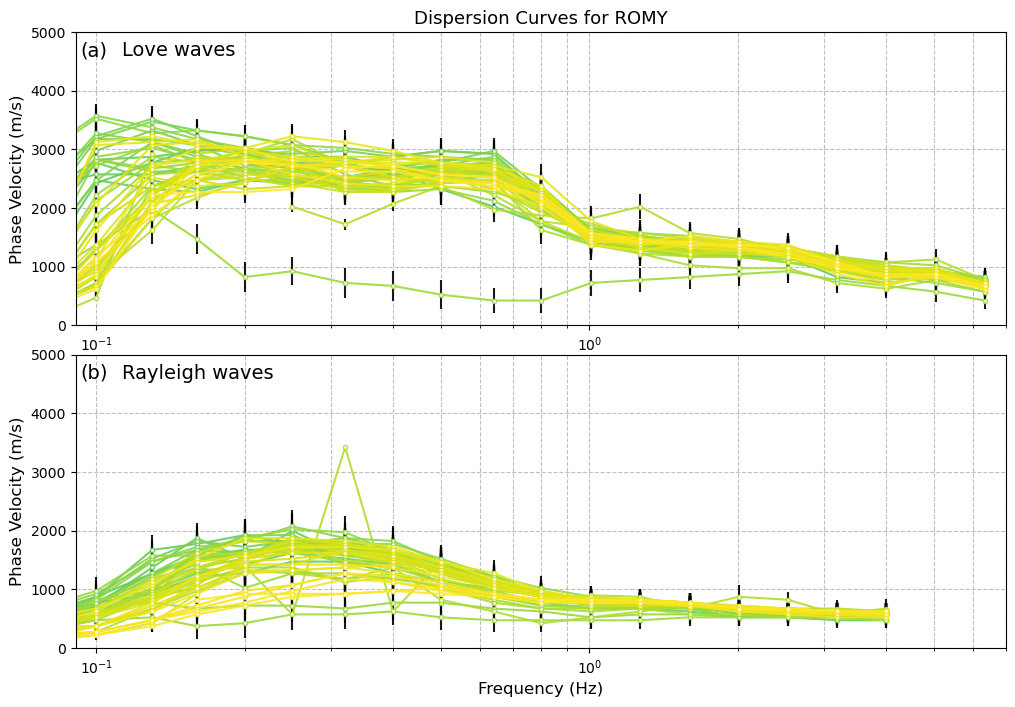

In [8]:
def __makeplot():

    import matplotlib.pyplot as plt
    import numpy as np
    import matplotlib as mpl

    Nrow, Ncol = 2, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(12, 8), sharex=False)

    plt.subplots_adjust(hspace=0.1)

    for _i, k in enumerate(data_love.keys()):

        _data = data_love[k]

        if np.isnan(_data['median'].astype(float)).all():
            print(f" -> all nan {k}")
            continue

        _data.dropna(inplace=True)

        try:
            ax[0].errorbar(_data['frequency'].astype(float),
                           _data['median'].astype(float),
                           yerr=_data['std'].astype(float),
                           ls="-", ms=3, marker="o", label=k,
                           ecolor="k", markerfacecolor="w",
                           color=config['date_colors'][k], alpha=0.9
                           )
        except:
            pass

    for _i, k in enumerate(data_rayl.keys()):

        _data = data_rayl[k]
        _data.dropna(inplace=True)

        try:
            ax[1].errorbar(_data['frequency'].astype(float),
                           np.array(_data['median'].astype(float)),
                           yerr=_data['std'].astype(float),
                           ls="-", ms=3, marker="o", label=k,
                           ecolor="k", markerfacecolor="w",
                           color=config['date_colors'][k], alpha=0.9
                           )
        except Exception as e:
            print(e)
            pass

    for n in range(2):
        ax[n].set_xscale("log")

        ax[n].set_ylim(0, 5000)

        ax[n].grid(which="both", ls="--", color="grey", alpha=0.5, zorder=0)

        ax[n].set_xlim(config['fmin'], config['fmax'])

    ax[0].set_ylabel("Phase Velocity (m/s)", fontsize=font)
    ax[1].set_ylabel("Phase Velocity (m/s)", fontsize=font)
    ax[1].set_xlabel("Frequency (Hz)", fontsize=font)
    ax[0].set_title("Dispersion Curves for ROMY", fontsize=font+1)

    for _k, ll in enumerate(['(a)', '(b)']):
        ax[_k].text(.005, .97, ll, ha='left', va='top', transform=ax[_k].transAxes, fontsize=font+2)

    ax[0].text(.05, .97, "Love waves", ha='left', va='top', transform=ax[0].transAxes, fontsize=font+2)
    ax[1].text(.05, .97, "Rayleigh waves", ha='left', va='top', transform=ax[1].transAxes, fontsize=font+2)

    plt.show();
    return fig

fig = __makeplot();

fig.savefig(config['path_to_figs']+f"Dispersion_{config['tbeg']}_{config['tend']}.png", format="png", dpi=150, bbox_inches='tight')


### Plot as Bands

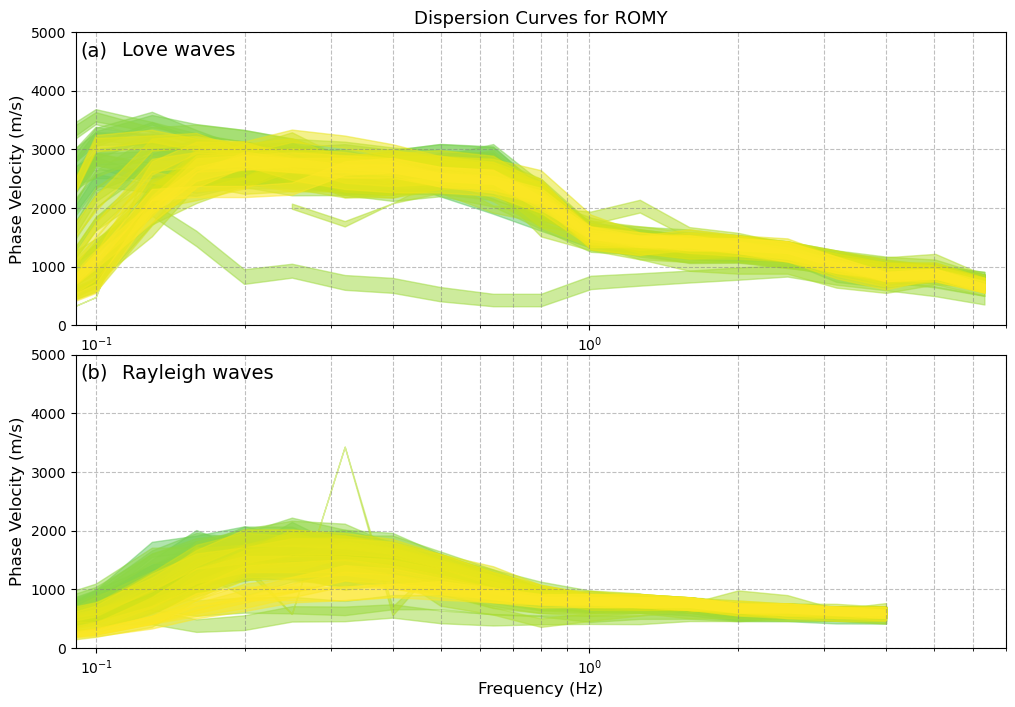

In [9]:
def __makeplot():

    import matplotlib.pyplot as plt
    import numpy as np
    import matplotlib as mpl

    Nrow, Ncol = 2, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(12, 8), sharex=False)

    plt.subplots_adjust(hspace=0.1)

    for _i, k in enumerate(data_love.keys()):

        _data = data_love[k]
        _data.dropna(inplace=True)

        try:
            ax[0].fill_between(_data['frequency'].astype(float),
                           np.array(_data['median'].astype(float))-_data['std'].astype(float)/2,
                           np.array(_data['median'].astype(float))+_data['std'].astype(float)/2,
                           color=config['date_colors'][k], alpha=0.5
                           )
        except:
            pass

    for _i, k in enumerate(data_rayl.keys()):

        _data = data_rayl[k]
        _data.dropna(inplace=True)

        try:
            ax[1].fill_between(_data['frequency'].astype(float),
                           np.array(_data['median'].astype(float))-_data['std'].astype(float)/2,
                           np.array(_data['median'].astype(float))+_data['std'].astype(float)/2,
                           color=config['date_colors'][k], alpha=0.5
                           )

        except Exception as e:
            print(e)
            pass

    for n in range(2):

        ax[n].set_xscale("log")

        ax[n].set_ylim(0, 5000)

        ax[n].grid(which="both", ls="--", color="grey", alpha=0.5, zorder=0)

        ax[n].set_xlim(config['fmin'], config['fmax'])

        # ax[n].legend(loc=1)

    ax[0].set_ylabel("Phase Velocity (m/s)", fontsize=font)
    ax[1].set_ylabel("Phase Velocity (m/s)", fontsize=font)
    ax[1].set_xlabel("Frequency (Hz)", fontsize=font)
    ax[0].set_title("Dispersion Curves for ROMY", fontsize=font+1)

    for _k, ll in enumerate(['(a)', '(b)']):
        ax[_k].text(.005, .97, ll, ha='left', va='top', transform=ax[_k].transAxes, fontsize=font+2)

    ax[0].text(.05, .97, "Love waves", ha='left', va='top', transform=ax[0].transAxes, fontsize=font+2)
    ax[1].text(.05, .97, "Rayleigh waves", ha='left', va='top', transform=ax[1].transAxes, fontsize=font+2)

    plt.show();
    return fig

fig = __makeplot();

fig.savefig(config['path_to_figs']+f"Dispersion_{config['tbeg']}_{config['tend']}.png", format="png", dpi=150, bbox_inches='tight')


### Store Data

In [10]:
for n, k in enumerate(data_love.keys()):

    if "202409" in k:

        dat = data_love[k]

        dfout = DataFrame()
        dfout['freq'] = dat['frequency']
        dfout['velo'] = dat['median']

        dfout.to_csv(data_path+f"VelocityChanges/dinvr/love/{k}_love.disp",
                     index=False, sep=' ', header=False, quotechar="#"
                    )


In [11]:
for n, k in enumerate(data_rayl.keys()):

    if "202409" in k:

        dat = data_rayl[k]

        dfout = DataFrame()
        dfout['freq'] = dat['frequency']
        dfout['velo'] = dat['median']

        dfout.to_csv(data_path+f"VelocityChanges/dinvr/rayleigh/{k}_rayl.disp",
                     index=False, sep=' ', header=False, quotechar="#"
                    )


## Plot Over Time

In [12]:
def __get_mesh(_data):

    X = np.array([k for k in _data.keys()])
    Y = _data[X[0]]['frequency']

    # get dates
    dates = date_range(config['tbeg'], config['tend'])

    # modify dates
    dates = np.array([str(_d)[:10].replace('-', '') for _d in dates])

    # define sizes
    NY, NX = len(_data[X[0]]['frequency']), len(dates)

    Z = []
    for _d in dates[:-1]:
        if _d in _data.keys():
            _tmp = [float(x) for x in _data[_d]['median'].values]
            Z.append(np.array(_tmp))
        else:
            Z.append(np.ones(NY)*np.nan)

    Y = np.append(Y, 0.00001)

    X = np.arange(0, len(dates), 1)

    mesh = {}
    mesh['X'] = np.array(X)
    mesh['Y'] = np.array(Y)
    mesh['Z'] = np.array(Z).T
    mesh['dates'] = dates

    return mesh

In [13]:
mesh_l = __get_mesh(data_love)
mesh_r = __get_mesh(data_rayl)

/tmp/ipykernel_164992/231797058.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(tcklbls)
/tmp/ipykernel_164992/231797058.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(tcklbls)


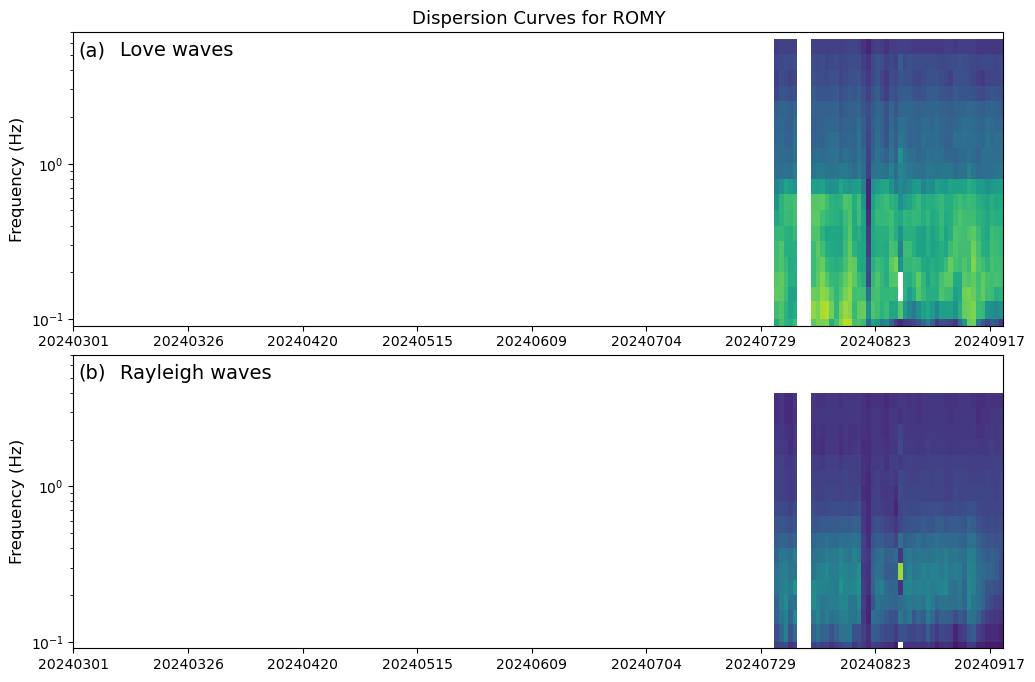

In [14]:
def __makeplot():

    import matplotlib.pyplot as plt
    import numpy as np
    import matplotlib as mpl

    Nrow, Ncol = 2, 1

    cmap = plt.get_cmap("viridis")

    vmin, vmax = 0, 4000

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(12, 8), sharex=False)

    plt.subplots_adjust(hspace=0.1)
    try:
        ax[0].pcolormesh(mesh_l['X'], mesh_l['Y'], mesh_l['Z'],
                         vmin=vmin, vmax=vmax, label="Love"
                        )
        ax[0].set_yscale("log")
        ax[0].set_ylim(mesh_l['Y'][-2], mesh_l['Y'][1])
    except:
        pass

    try:
        ax[1].pcolormesh(mesh_r['X'], mesh_r['Y'], mesh_r['Z'],
                         vmin=vmin, vmax=vmax, label="Rayleigh"
                        )
        ax[1].set_yscale("log")
        ax[1].set_ylim(mesh_r['Y'][-2], mesh_r['Y'][1])
    except:
        pass

    for n in range(2):

        # ax[n].grid(which="both", ls="--", color="grey", alpha=0.5, zorder=0)

        # ax[n].legend(loc=1)

        ax[n].set_ylim(config['fmin'], config['fmax'])

    # ax[0].set_ylabel("Phase Velocity (m/s)", fontsize=font)
    # ax[1].set_ylabel("Phase Velocity (m/s)", fontsize=font)
    ax[0].set_ylabel("Frequency (Hz)", fontsize=font)
    ax[1].set_ylabel("Frequency (Hz)", fontsize=font)
    # ax[1].set_xlabel("Time (days)", fontsize=font)

    ax[0].set_title("Dispersion Curves for ROMY", fontsize=font+1)

    tcks = ax[1].get_xticks()
    tcklbls = [mesh_r['dates'][int(_t)] for _t in tcks[:-1]]
    ax[0].set_xticklabels(tcklbls)
    ax[1].set_xticklabels(tcklbls)

    for _k, ll in enumerate(['(a)', '(b)']):
        ax[_k].text(.005, .97, ll, ha='left', va='top', transform=ax[_k].transAxes, fontsize=font+2)

    ax[0].text(.05, .97, "Love waves", ha='left', va='top', transform=ax[0].transAxes, fontsize=font+2)
    ax[1].text(.05, .97, "Rayleigh waves", ha='left', va='top', transform=ax[1].transAxes, fontsize=font+2)

    plt.show();
    return fig

fig = __makeplot();

fig.savefig(config['path_to_figs']+f"Dispersion_{config['tbeg']}_{config['tend']}.png", format="png", dpi=150, bbox_inches='tight')
